In [2]:
from functools import lru_cache

import matplotlib
import matplotlib as plt
import pandas as pd
import requests
from ebi_eva_internal_pyutils.metadata_utils import get_metadata_connection_handle
from ebi_eva_internal_pyutils.pg_utils import get_all_results_for_query
from requests import HTTPError

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Daily and Yearly plot for FTP and WEB traffic

In [3]:
private_config_xml_file = 'maven_settings.xml'
query_ftp = '''select event_ts, uhost,  file_name, file_size
           from eva_web_srvc_stats.ftp_traffic
           where file_size>0;'''

with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    all_ftp_df = pd.DataFrame(get_all_results_for_query(db_conn, query_ftp), columns =['event_ts', 'uhost', 'file_name', 'file_size'])

raw_ftp_df_daily = all_ftp_df.groupby(all_ftp_df.event_ts.dt.date).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc='sum'),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
raw_ftp_df_daily.reset_index(inplace=True)
raw_ftp_df_daily['year']=pd.DatetimeIndex(raw_ftp_df_daily.event_ts).year
raw_ftp_df_daily['month']=pd.to_datetime(raw_ftp_df_daily.event_ts).dt.strftime('%Y-%m')

In [4]:
query_web = '''select request_ts, client_ip, bytes_out
               from eva_web_srvc_stats.ws_traffic_useful_cols'''
with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    all_web_df = pd.DataFrame(get_all_results_for_query(db_conn, query_web), columns =['request_ts', 'client_ip', 'bytes_out'])
raw_web_df_daily = all_web_df.groupby(all_web_df.request_ts.dt.date).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc='count'))
raw_web_df_daily.reset_index(inplace=True)
raw_web_df_daily['year']=pd.DatetimeIndex(raw_web_df_daily.request_ts).year
raw_web_df_daily['month']=pd.to_datetime(raw_web_df_daily.request_ts).dt.strftime('%Y-%m')

In [5]:
def draw_box_plot(dataframe, column, group, xlabel, ylabel, x_rotation=0, fig_size=(7, 7), fontsize=16):
    ax = dataframe.boxplot(column, by=group, widths=0.9, color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                           medianprops=dict(linewidth=2, color='k'), grid=False, showfliers=False, showcaps=False, figsize=fig_size)
    ax.spines[['right', 'top']].set_visible(False)
    fig = ax.get_figure()
    fig.suptitle('')
    ax.tick_params(axis='x', rotation=x_rotation)
    ax.set_title('')
    ax.set_facecolor('white')
    ax.set_ylabel(ylabel, fontdict={'fontsize':fontsize})
    ax.set_xlabel(xlabel, fontdict={'fontsize':fontsize})
    ax.tick_params(axis='x', labelsize=fontsize-4)
    ax.tick_params(axis='y', labelsize=fontsize-4)
    return ax, fig

In [6]:
current_year_range = (2017,2018,2019,2020,2021,2022,2023,2024)
all_ftp_df_daily = raw_ftp_df_daily[raw_ftp_df_daily['year'].isin( current_year_range )]
all_web_df_daily = raw_web_df_daily[raw_web_df_daily['year'].isin( current_year_range )]

In [7]:
def _get_location(ip_address):
    response = requests.get('https://geolocation-db.com/json/' + ip_address)
    response.raise_for_status()
    return response.json()

cache={}
def get_location(ip_address):
    if ip_address not in cache:
        try:
            cache[ip_address] = _get_location(ip_address)
        except HTTPError:
            cache[ip_address] = {}
    return cache[ip_address]


## Number of daily FTP download request per year and month

In [12]:
len(cache)

19321

In [11]:
web_df_2023 = all_web_df[(all_web_df['request_ts'] > '2023-01-01') & (all_web_df['request_ts'] < '2024-01-01')]
web_df_2023['client_ip'].unique()
res = web_df_2023.apply(lambda row: get_location(row.client_ip), axis='columns', result_type='expand')
res

,country_code,country_name,city,postal,latitude,longitude,IPv4,state
320163,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
320164,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
320165,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
320179,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
320205,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
...,...,...,...,...,...,...,...,...
10670449,US,United States,None,None,37.751,-97.822,66.249.79.196,None
10670450,US,United States,None,None,37.751,-97.822,66.249.79.196,None
10670451,US,United States,None,None,37.751,-97.822,66.249.76.45,None
10670452,US,United States,None,None,37.751,-97.822,66.249.76.42,None


## IP address connected to EVA in 2023

/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_2888/1835700197.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


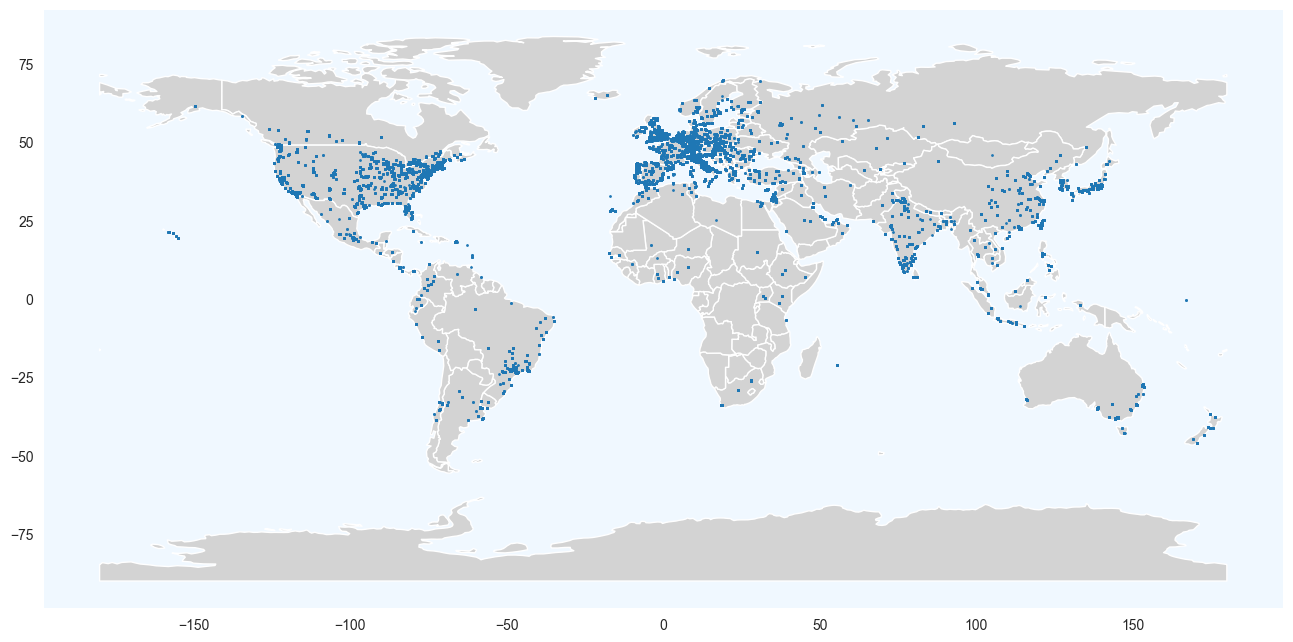

In [18]:
res = res[res.latitude!='Not found']


import geopandas as gpd
import geodatasets

import matplotlib.pyplot as plt

# Read the map
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# Plot the map
ax = countries.plot(color="white", figsize=(16,16))
# Plot the position of the IP addresses
ax.scatter(res["longitude"], res["latitude"], s=1)
ax.grid(False)
ax.set_facecolor("aliceblue")


## Connection to EVA

/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_2888/3265483582.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


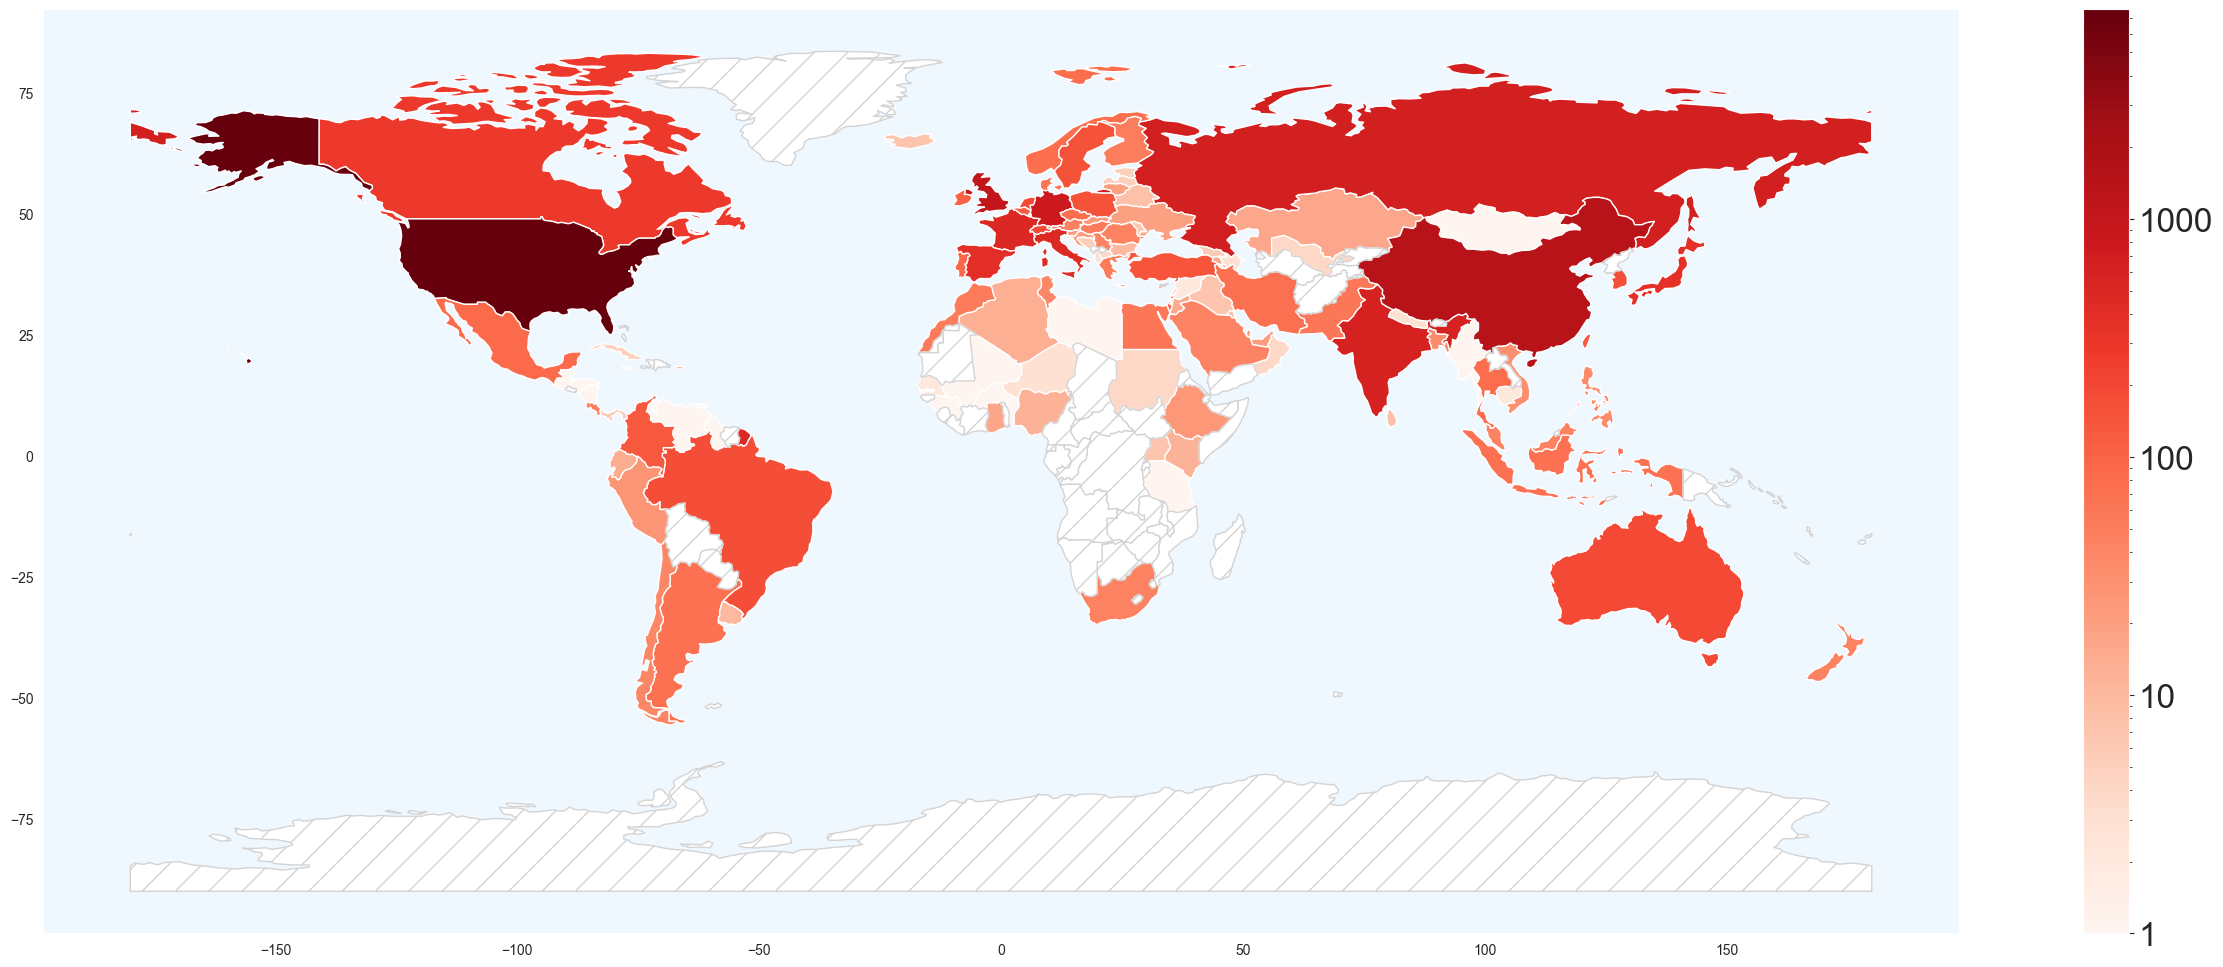

In [83]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#Plot the map
map_country_code = pd.read_csv('map_country_code.csv')

count_per_country = res.groupby(['country_code'])[['IPv4']].nunique()

count_per_country_with_code = count_per_country.merge(map_country_code, how='left', left_on='country_code', right_on='Alpha-2 code')

count_in_world = world.merge(count_per_country_with_code, how='outer', left_on='iso_a3', right_on='Alpha-3 code')
# count_in_world[count_in_world['IPv4'].isna()]
count_in_world
ax = count_in_world.plot(column='IPv4', legend=True, cmap=matplotlib.colormaps['Reds'], figsize=(32, 12),
                         norm=matplotlib.colors.LogNorm(),
                        missing_kwds={
                            "color": "white",
                            "edgecolor": "lightgrey",
                            "hatch": "/",
                            "label": "Missing values",
                         })
ax.grid(False)
ax.set_facecolor("aliceblue")
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.set_yticks(ticks=[1,10,100,1000], labels=['1','10','100', '1000'])
cb_ax.tick_params(labelsize=24)
# world
# ax = world.plot(color="white", figsize=(16,16))
# # Plot the position of the IP addresses
# ax.scatter(res["longitude"], res["latitude"], s=1)
# ax.grid(False)
# ax.set_facecolor("aliceblue")

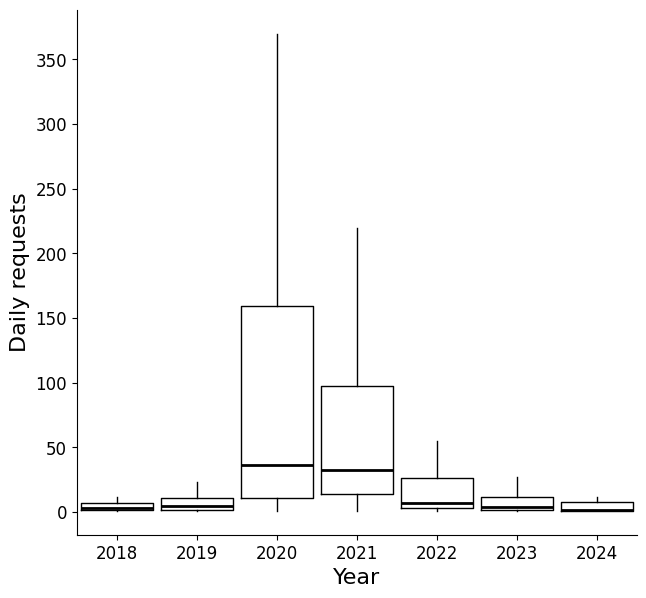

In [78]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'nb_request', 'year', xlabel='Year', ylabel='Daily requests')

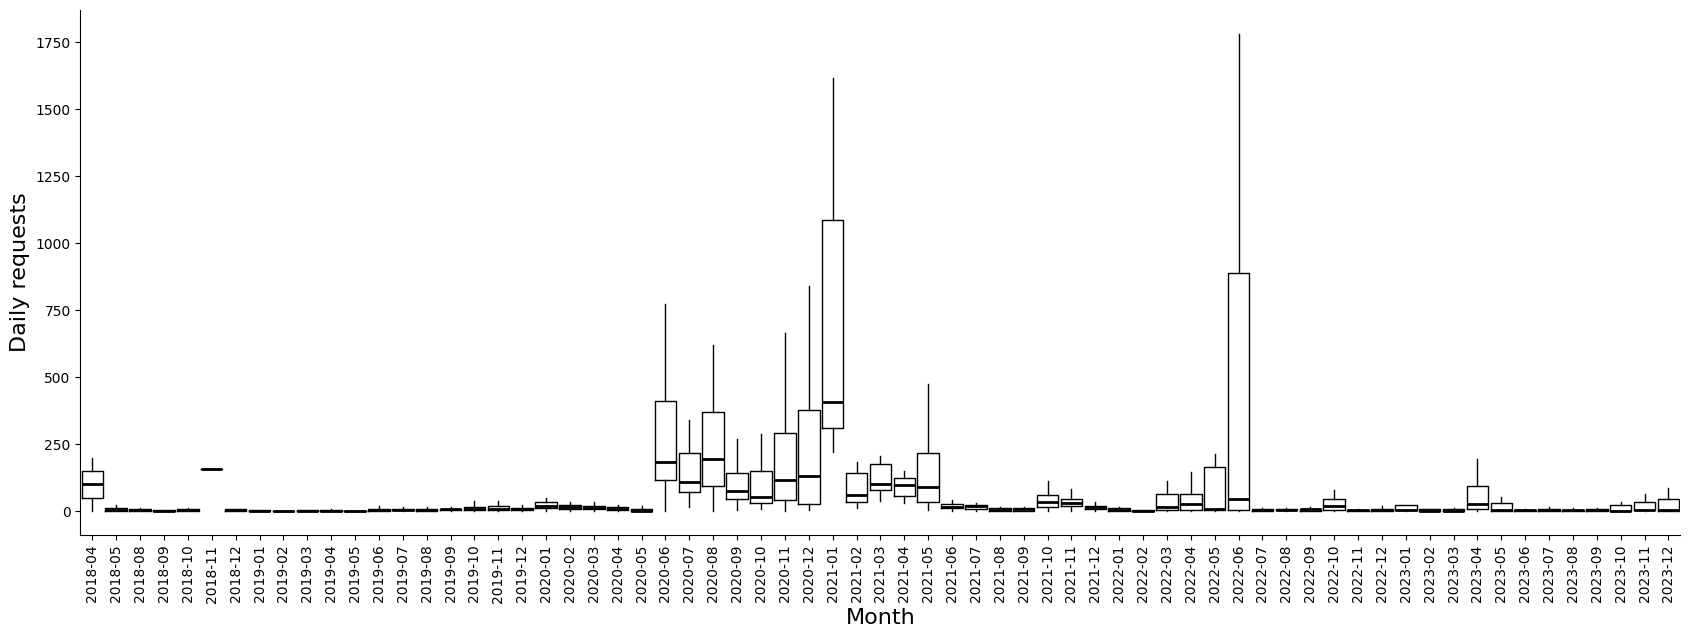

In [9]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'nb_request', 'month', xlabel='Month', ylabel='Daily requests', x_rotation=90, fig_size=(20, 7))

## Number of daily FTP unique visitor per year and month

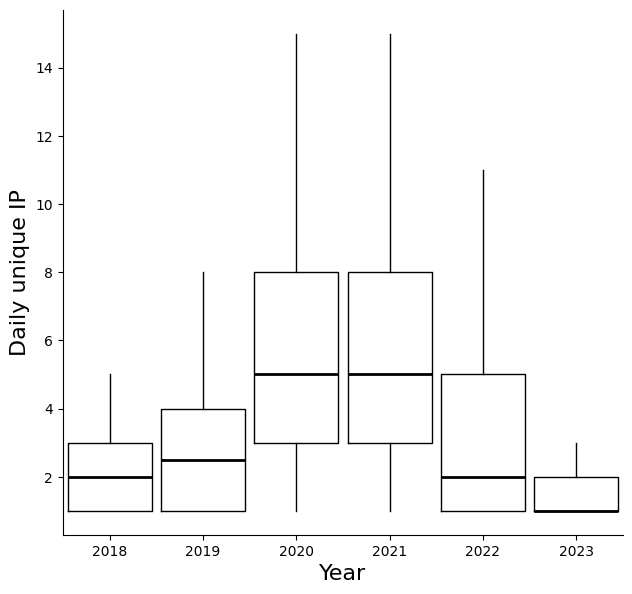

In [10]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'uhost', 'year', xlabel='Year', ylabel='Daily unique IP')

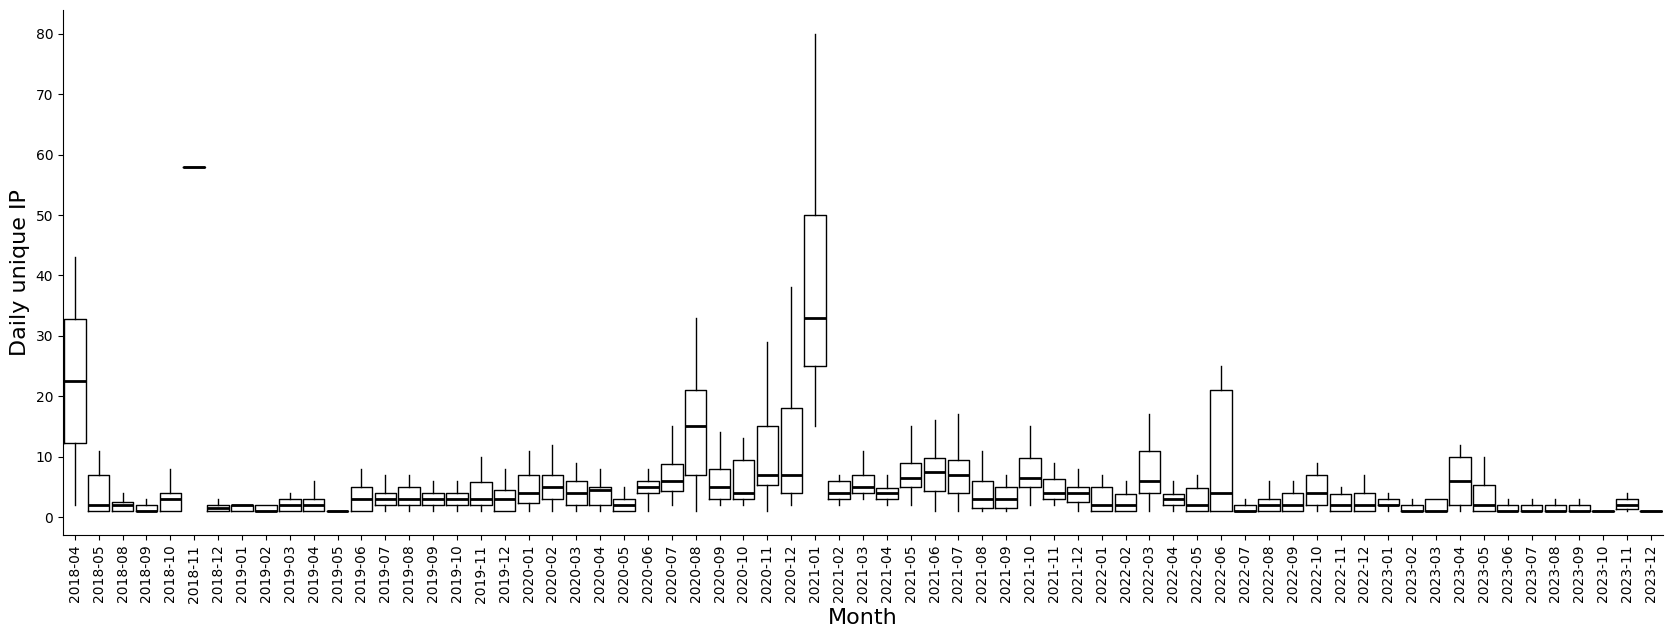

In [11]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'uhost', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

## Number of daily FTP download amount per year and month

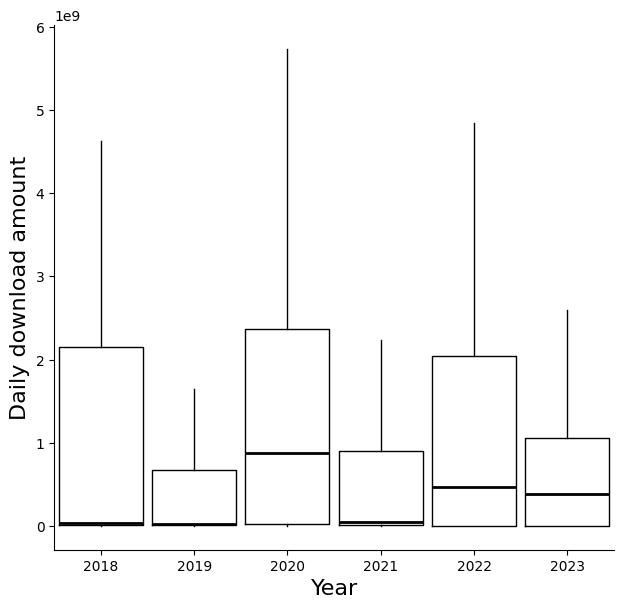

In [12]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'file_size', 'year', xlabel='Year', ylabel='Daily download amount')

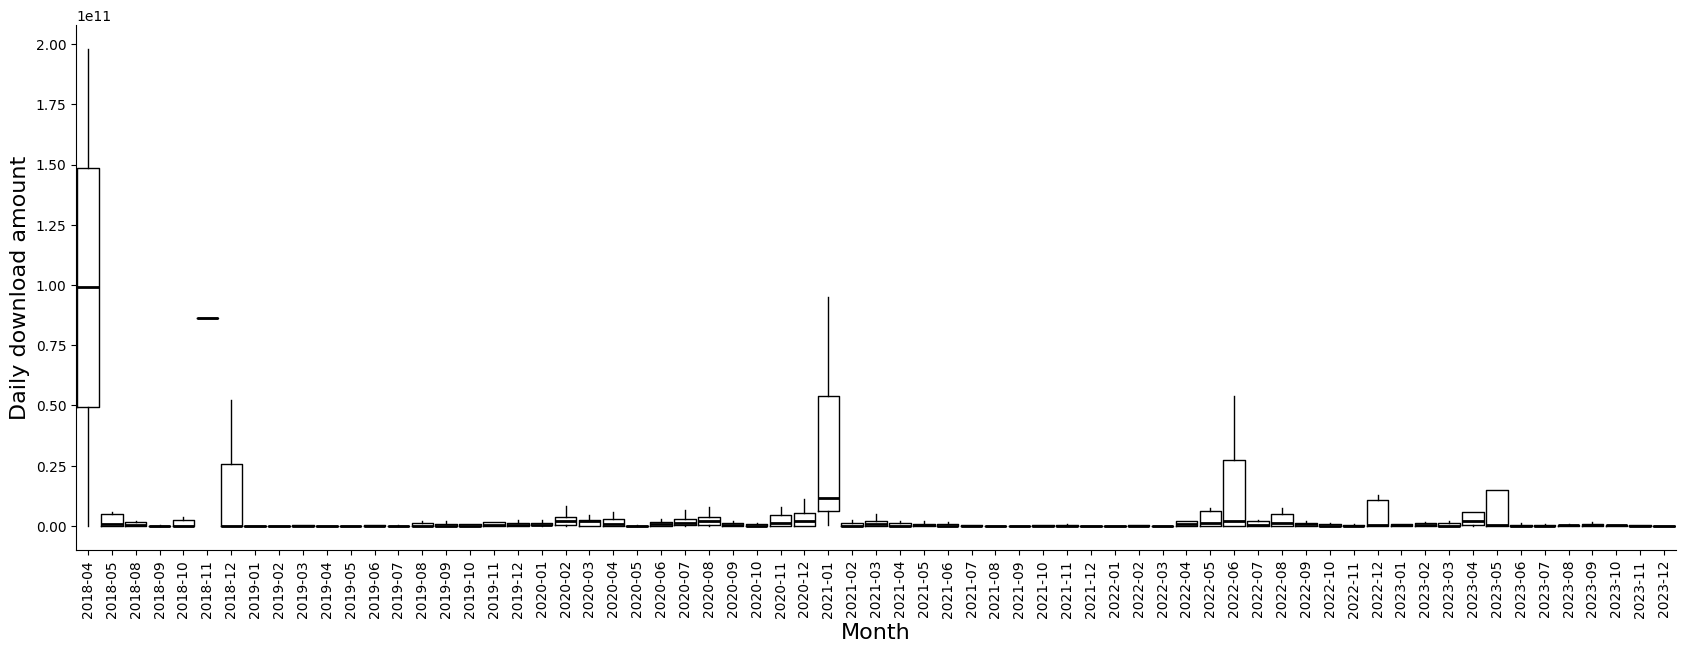

In [13]:
ax, fig=draw_box_plot(all_ftp_df_daily, 'file_size', 'month', xlabel='Month', ylabel='Daily download amount', x_rotation=90, fig_size=(20, 7))

## Number of daily web request per year and month

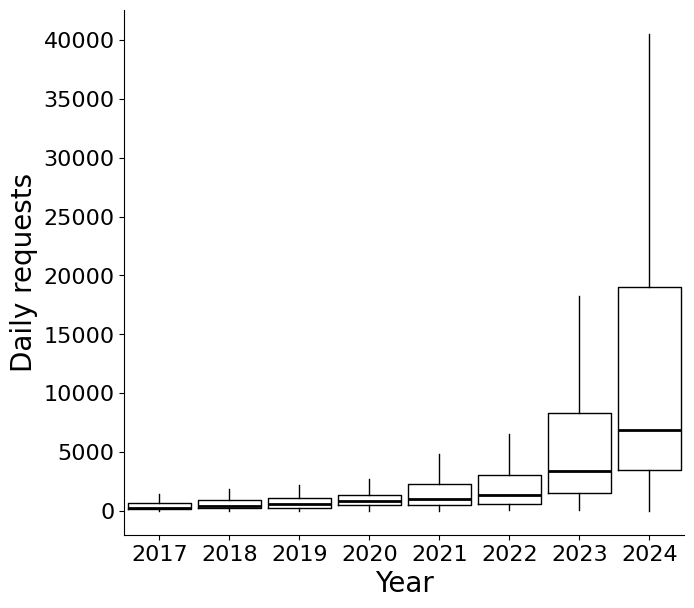

In [55]:
ax, fig=draw_box_plot(all_web_df_daily, 'nb_request', 'year', xlabel='Year', ylabel='Daily requests', fontsize=20)

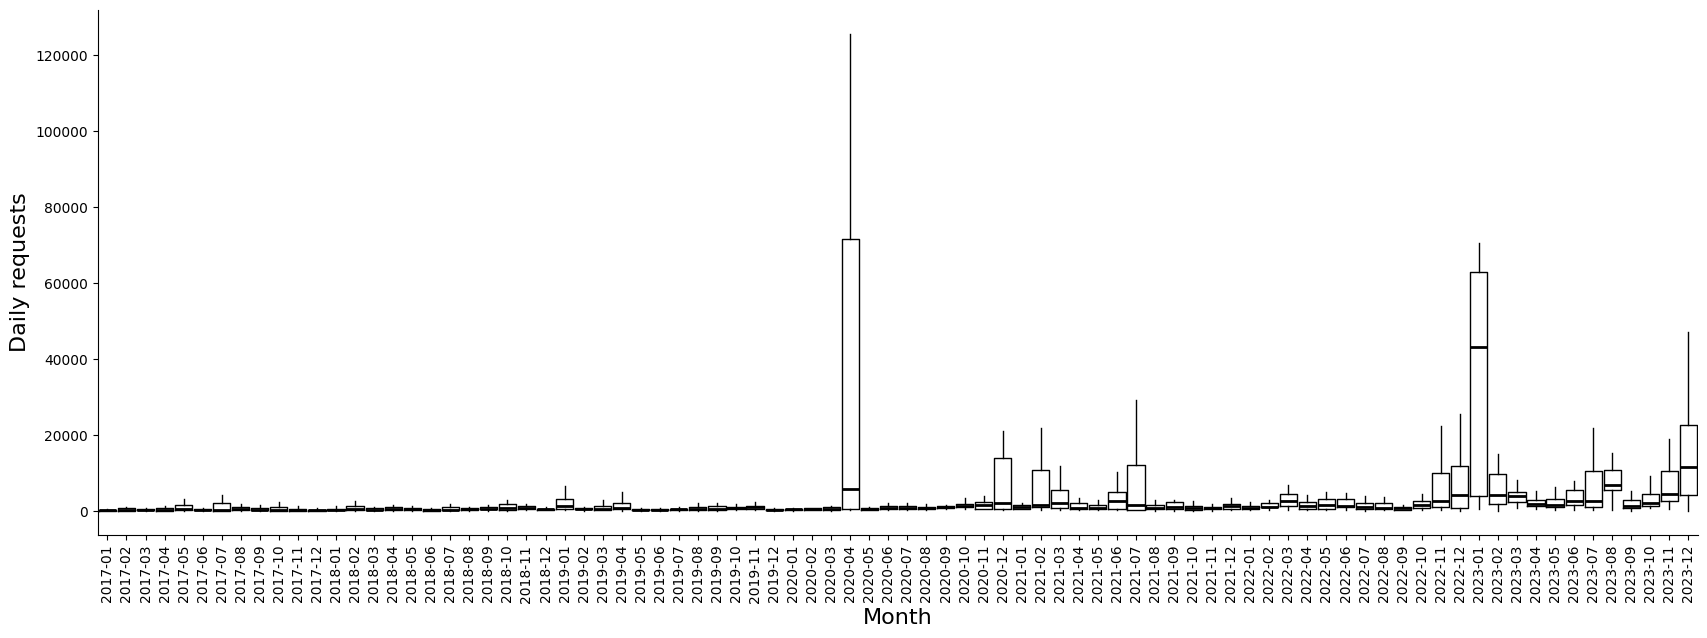

In [15]:
ax, fig=draw_box_plot(all_web_df_daily, 'nb_request', 'month', xlabel='Month', ylabel='Daily requests', x_rotation=90, fig_size=(20, 7))

## Number of daily web unique visitor per year and month

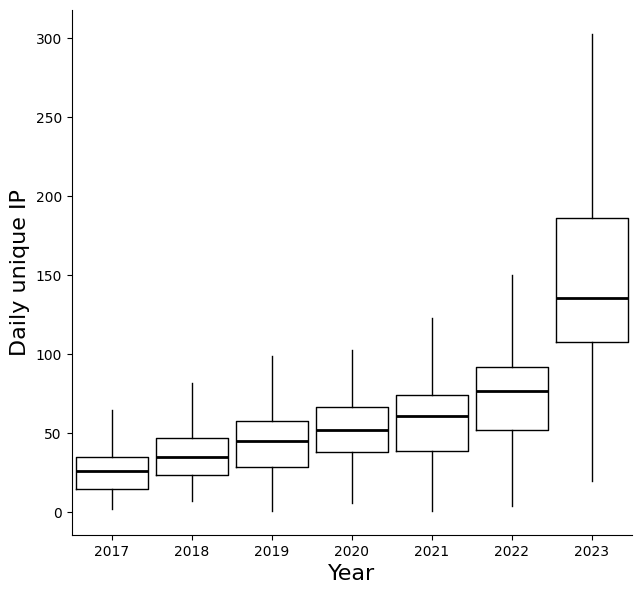

In [16]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'year', xlabel='Year', ylabel='Daily unique IP')

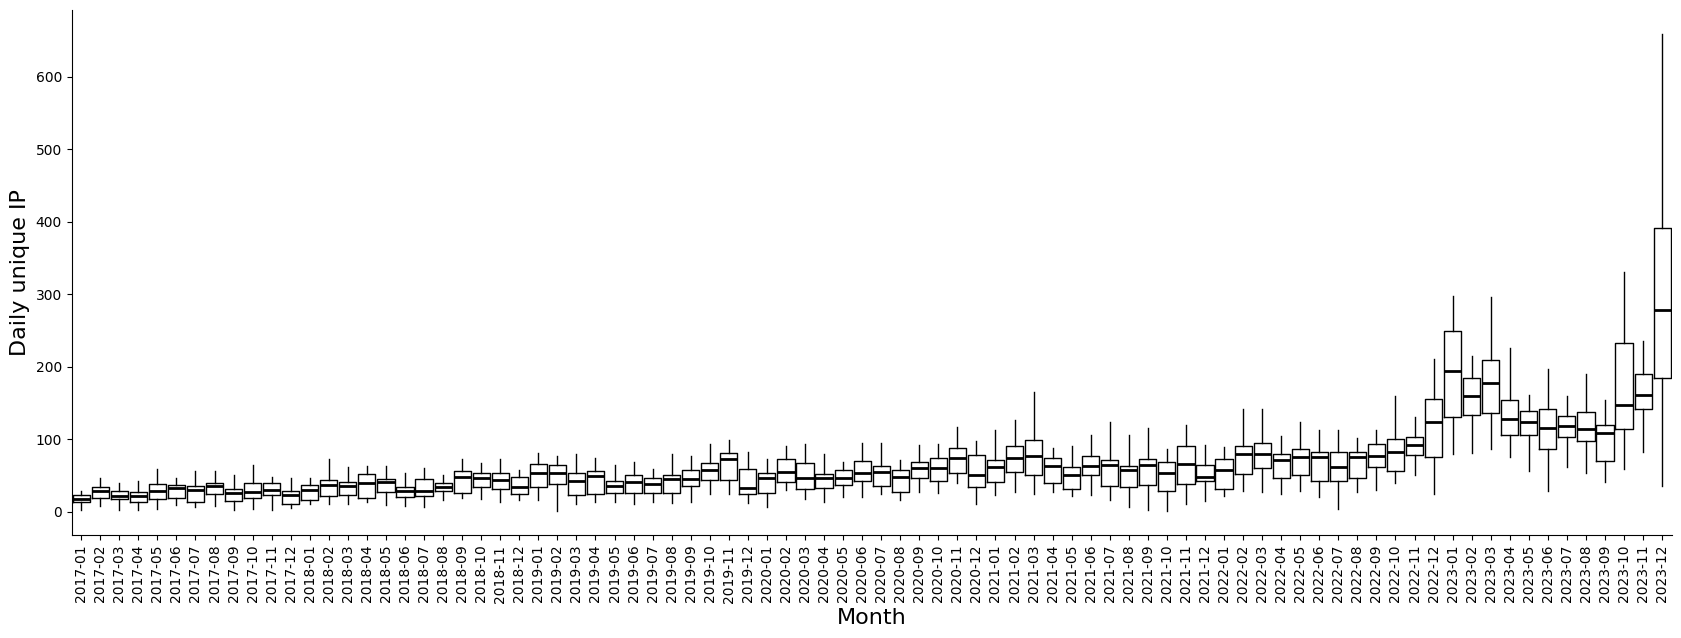

In [17]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

## Number of daily web download amount per year and month

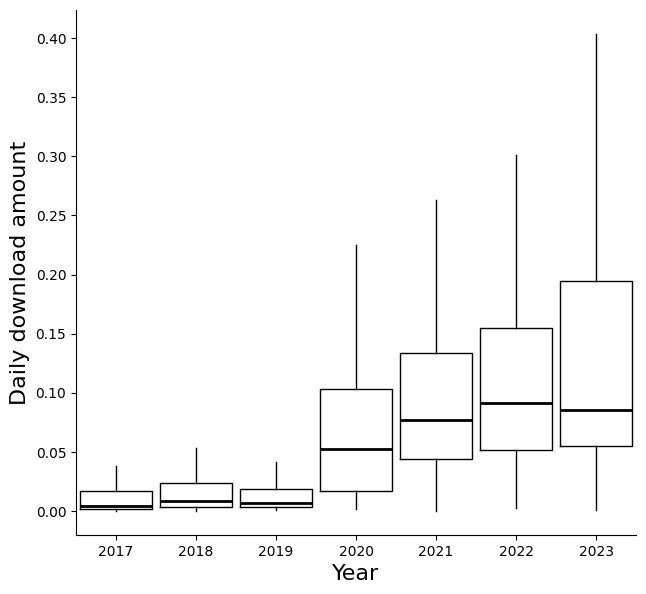

In [18]:
ax, fig=draw_box_plot(all_web_df_daily, 'bytes_out', 'year', xlabel='Year', ylabel='Daily download amount')

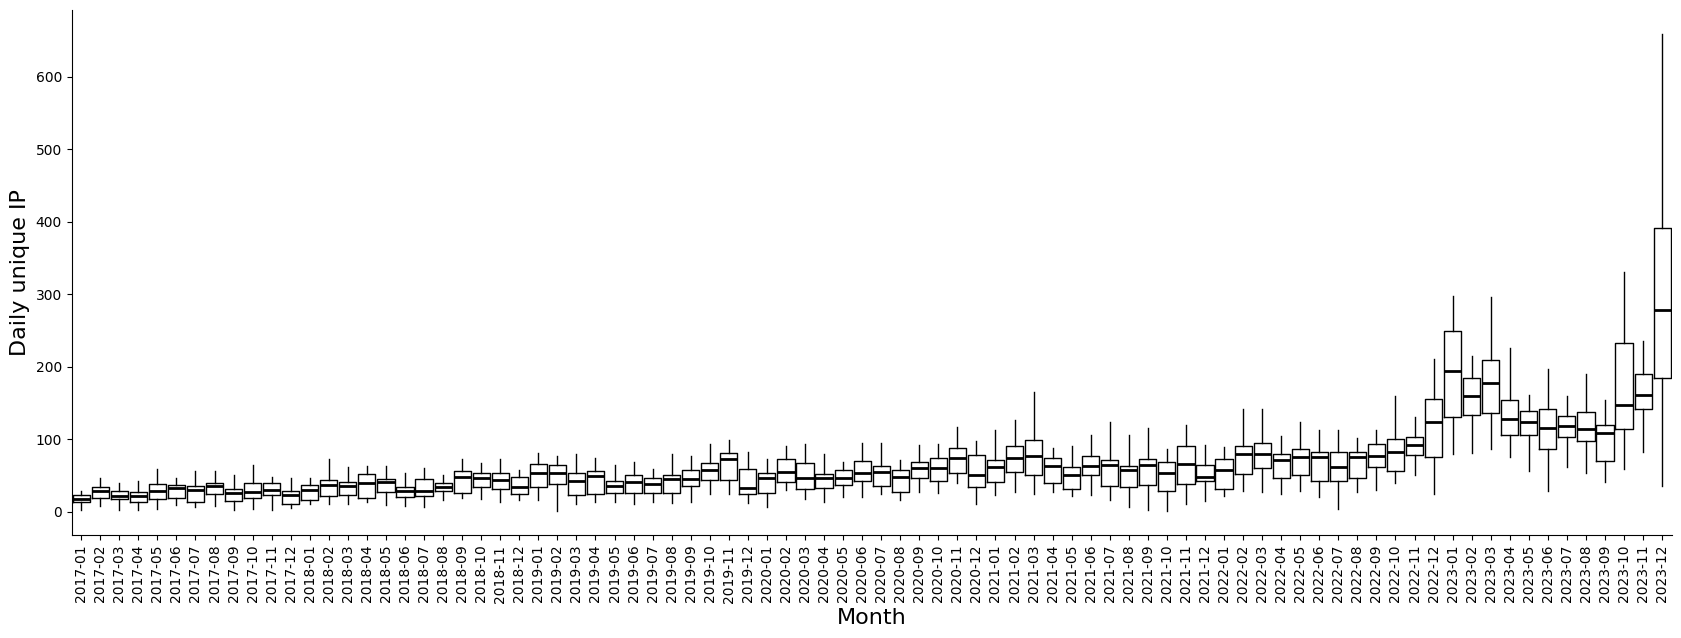

In [19]:
ax, fig=draw_box_plot(all_web_df_daily, 'unique_ip', 'month', xlabel='Month', ylabel='Daily unique IP', x_rotation=90, fig_size=(20, 7))

In [20]:
all_web_df['year']=pd.DatetimeIndex(all_web_df.request_ts).year
all_web_df['month']=pd.to_datetime(all_web_df.request_ts).dt.strftime('%Y-%m')
current_year_range = range(2017,2024)

In [21]:
all_web_df_yearly = all_web_df[all_web_df['year'].isin( current_year_range )].groupby(all_web_df.year).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc=lambda x: len(x)/1000000))
all_web_df_yearly.reset_index(inplace=True)
all_web_df_monthly = all_web_df[all_web_df['year'].isin( current_year_range )].groupby(all_web_df.month).agg(
    bytes_out=pd.NamedAgg(column='bytes_out', aggfunc=lambda x: sum(x)/1000000000),
    unique_ip=pd.NamedAgg(column='client_ip', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='client_ip', aggfunc=lambda x: len(x)/1000000))
all_web_df_monthly.reset_index(inplace=True)

In [22]:
all_ftp_df['year'] = pd.DatetimeIndex(all_ftp_df.event_ts).year
all_ftp_df['month']=pd.to_datetime(all_ftp_df.event_ts).dt.strftime('%Y-%m')
current_year_range = range(2017,2024)

In [23]:
all_ftp_df_yearly = all_ftp_df[all_ftp_df['year'].isin( current_year_range )].groupby(all_ftp_df.year).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc=lambda x: sum(x)/1000000000),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
all_ftp_df_yearly.reset_index(inplace=True)
all_ftp_df_monthly = all_ftp_df[all_ftp_df['year'].isin( current_year_range )].groupby(all_ftp_df.month).agg(
    file_size=pd.NamedAgg(column='file_size', aggfunc=lambda x: sum(x)/1000000000),
    uhost=pd.NamedAgg(column='uhost', aggfunc='nunique'),
    nb_request=pd.NamedAgg(column='uhost', aggfunc='count'))
all_ftp_df_monthly.reset_index(inplace=True)

In [57]:
def draw_bar_plot(dataframe, x, y, xlabel, ylabel, x_rotation=0, fig_size=(7, 7), fontsize=16):
    ax = dataframe.plot.bar(x=x, y=y, width = .9, color='k', legend=False, grid=False, fontsize=16, figsize=fig_size)
    ax.tick_params(axis='x', rotation=x_rotation)
    ax.set_facecolor('white')
    ax.set_ylabel(ylabel, fontdict={'fontsize':fontsize})
    ax.set_xlabel(xlabel, fontdict={'fontsize':fontsize})
    ax.tick_params(axis='x', labelsize=fontsize-4)
    ax.tick_params(axis='y', labelsize=fontsize-4)
    return ax

## Total Number of Gigabytes downloaded from FTP per year and month

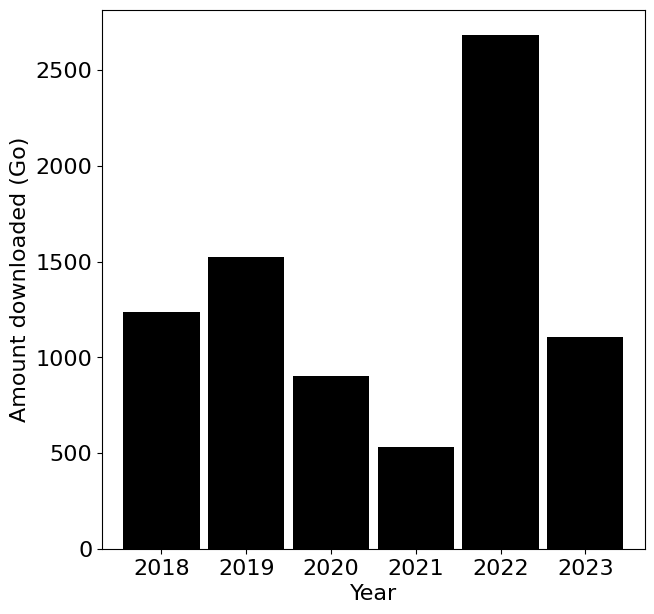

In [25]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='file_size', ylabel='Amount downloaded (Go)', xlabel='Year')

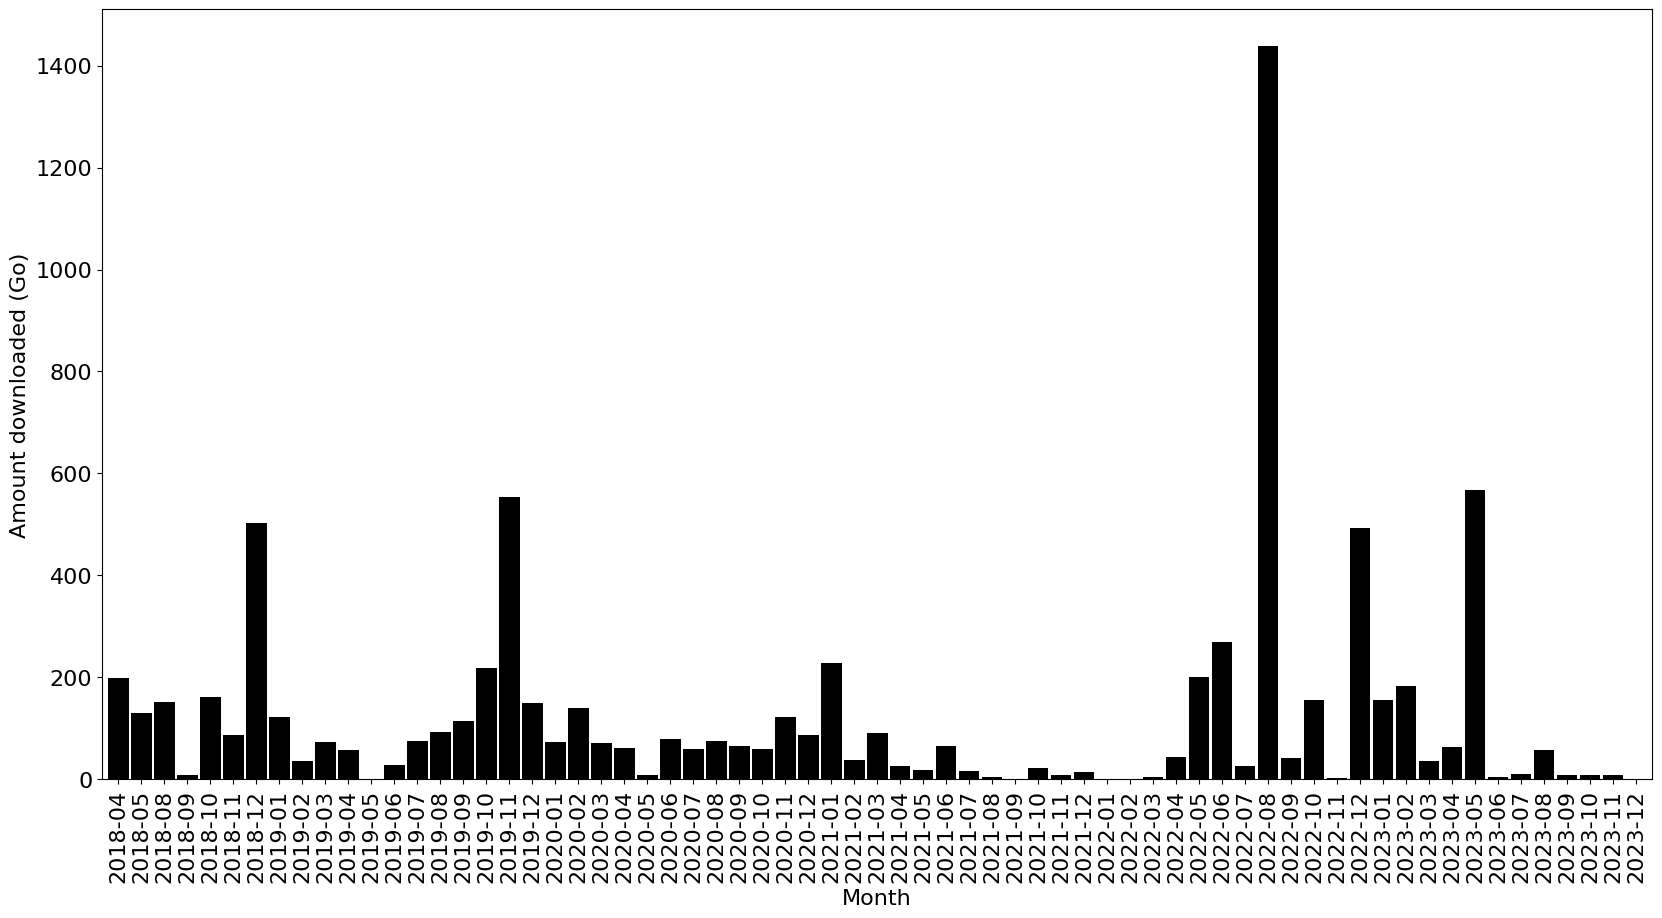

In [26]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='file_size', ylabel='Amount downloaded (Go)', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of unique visitor to the FTP per year and month

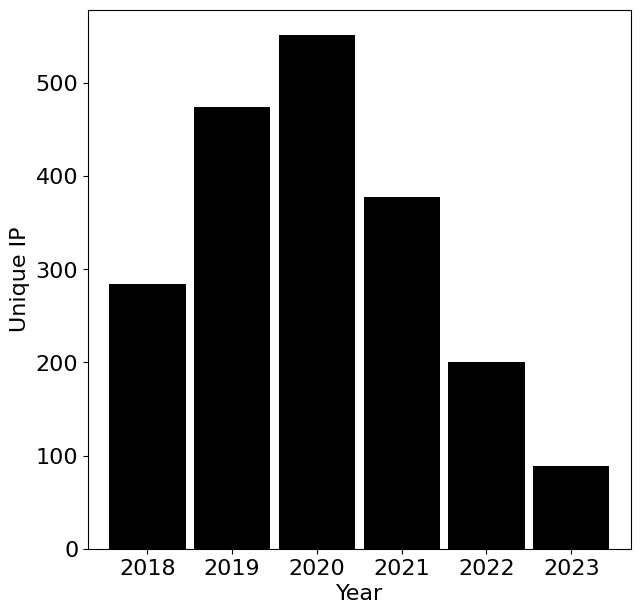

In [27]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='uhost', ylabel='Unique IP', xlabel='Year')

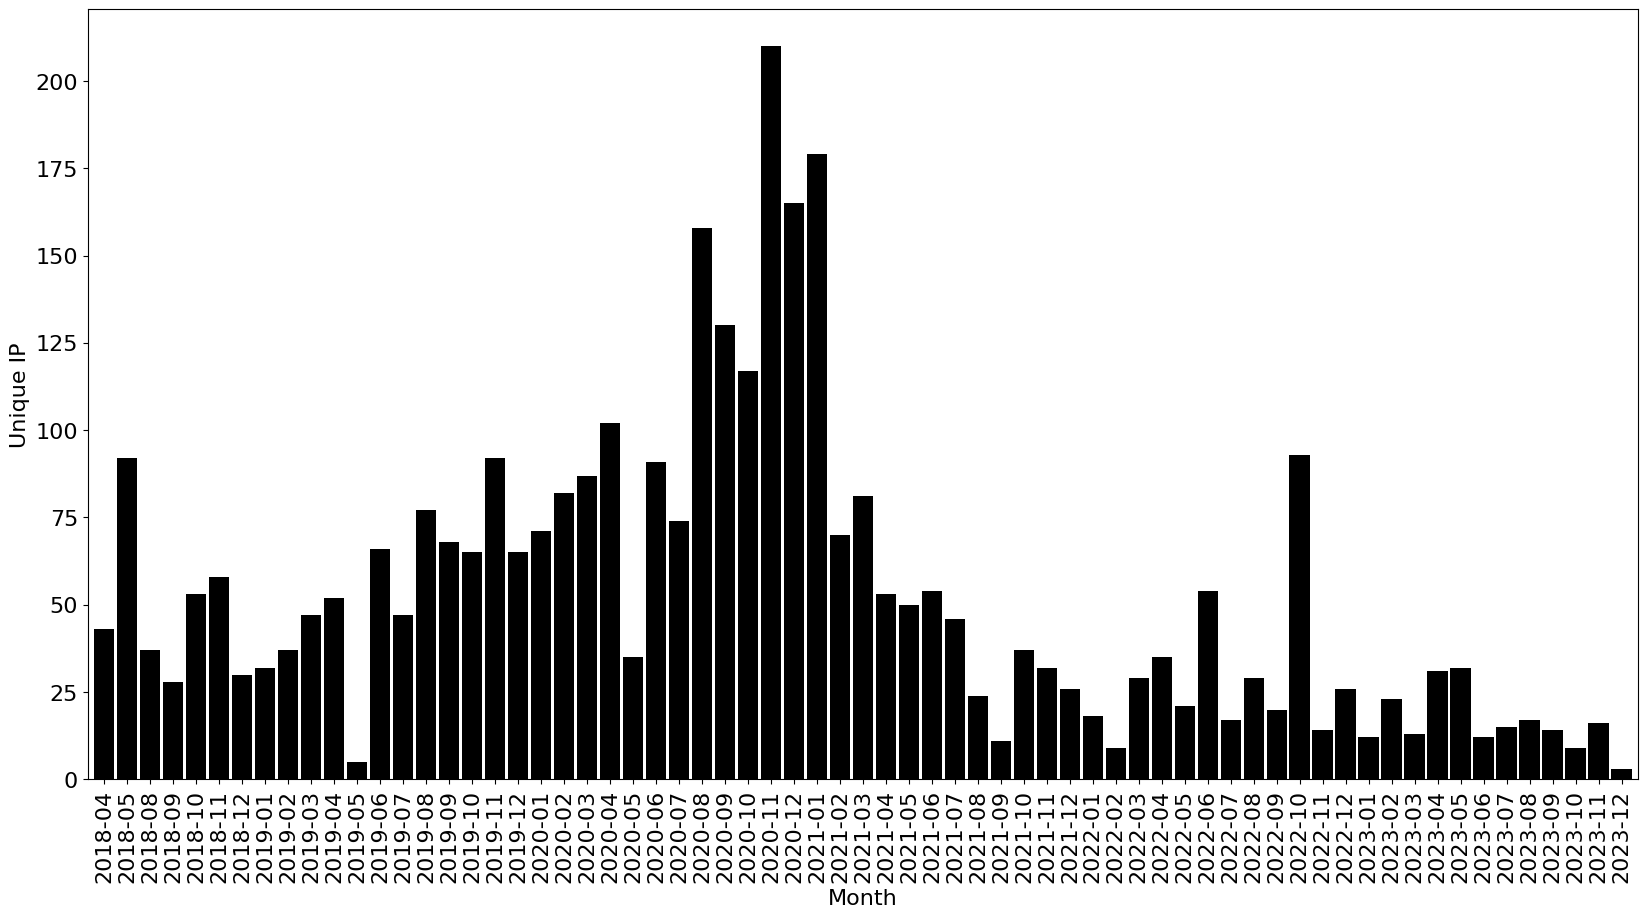

In [28]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='uhost', ylabel='Unique IP', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of request to the FTP per year and month

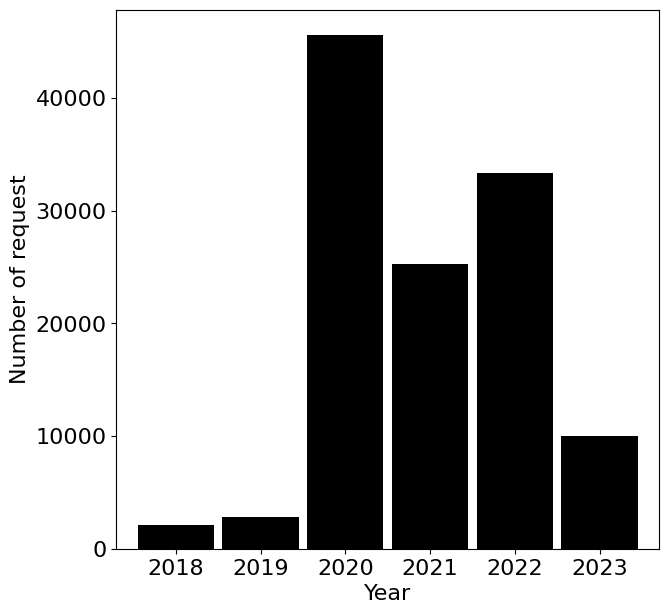

In [29]:
ax = draw_bar_plot(all_ftp_df_yearly, x='year', y='nb_request', ylabel='Number of request', xlabel='Year')

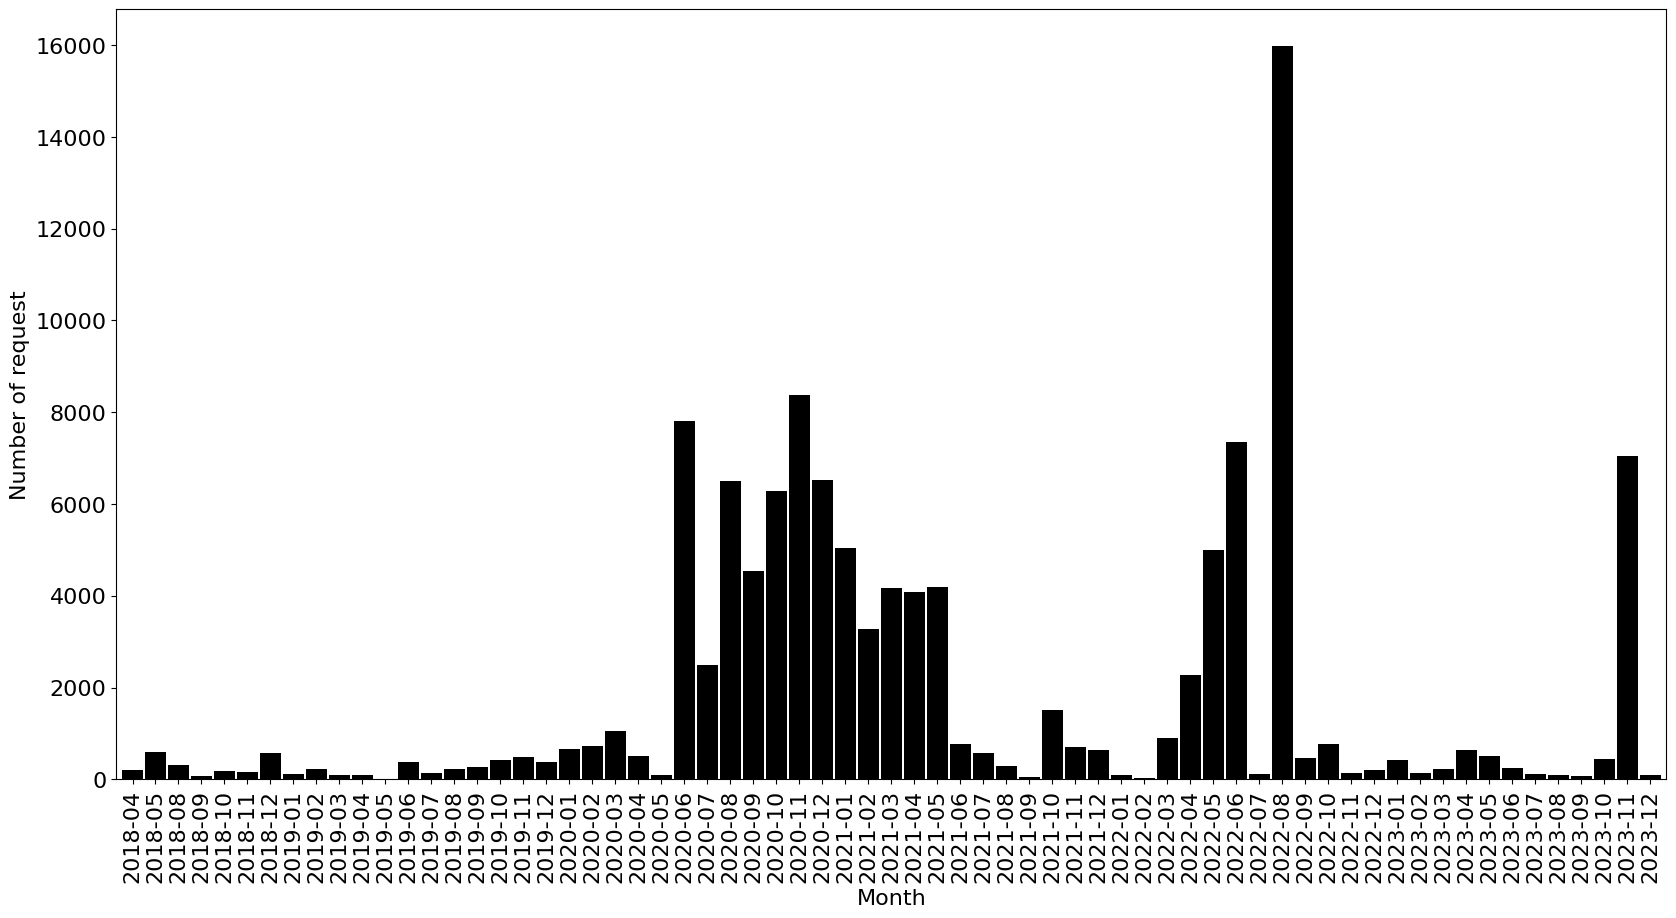

In [30]:
ax = draw_bar_plot(all_ftp_df_monthly, x='month', y='nb_request', ylabel='Number of request', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of Gigabytes downloaded from Website per year and month

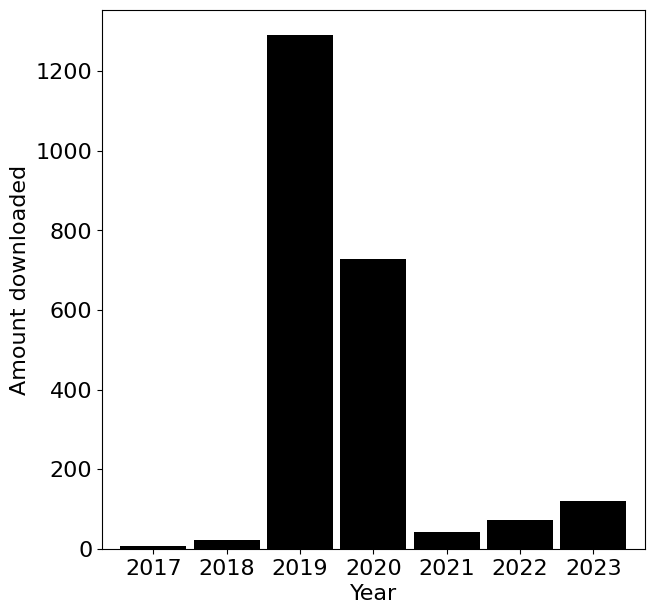

In [31]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='bytes_out', ylabel='Amount downloaded', xlabel='Year')

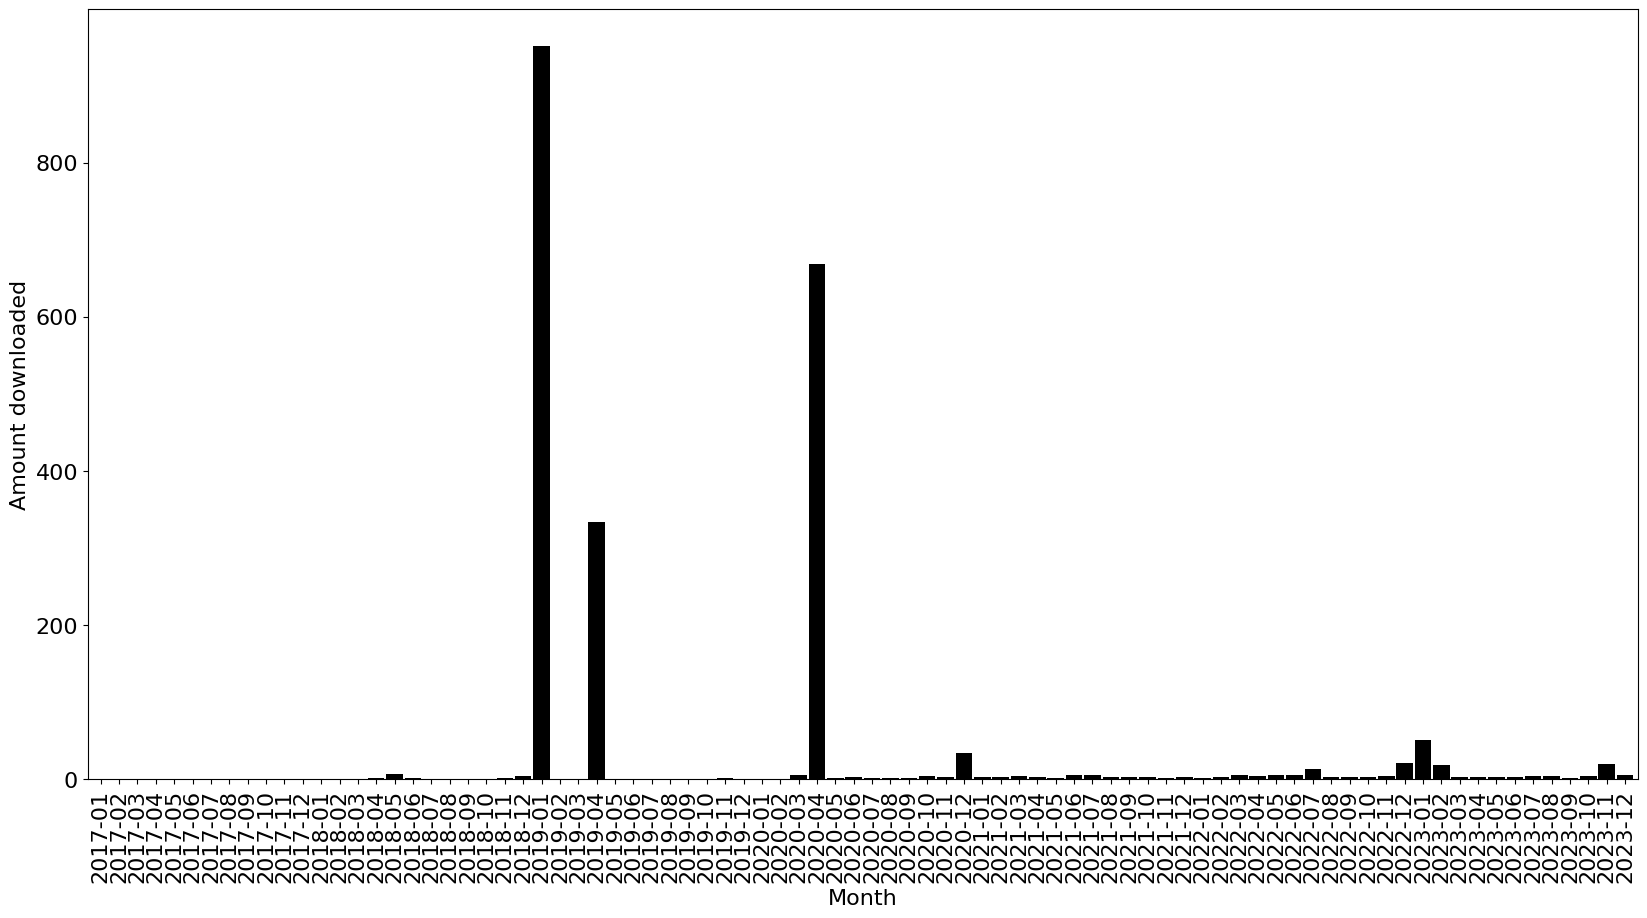

In [32]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='bytes_out', ylabel='Amount downloaded', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of unique visitor to the website per year and month

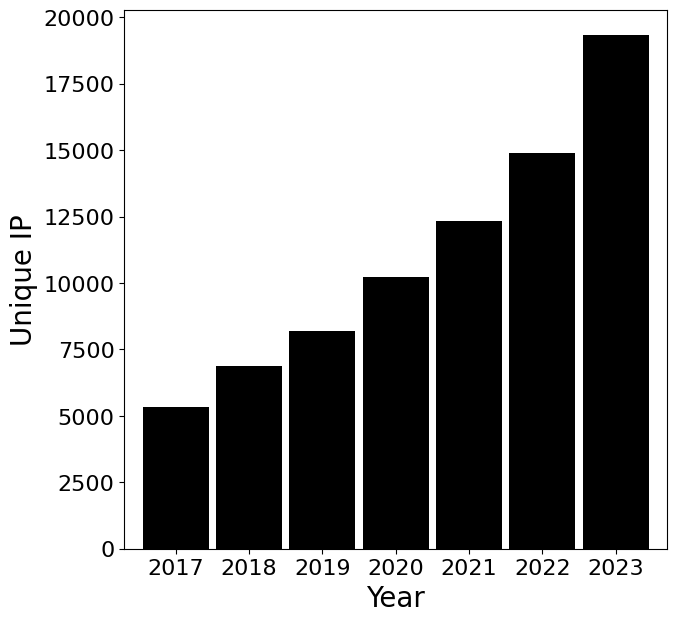

In [61]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='unique_ip', ylabel='Unique IP', xlabel='Year', fontsize=20)

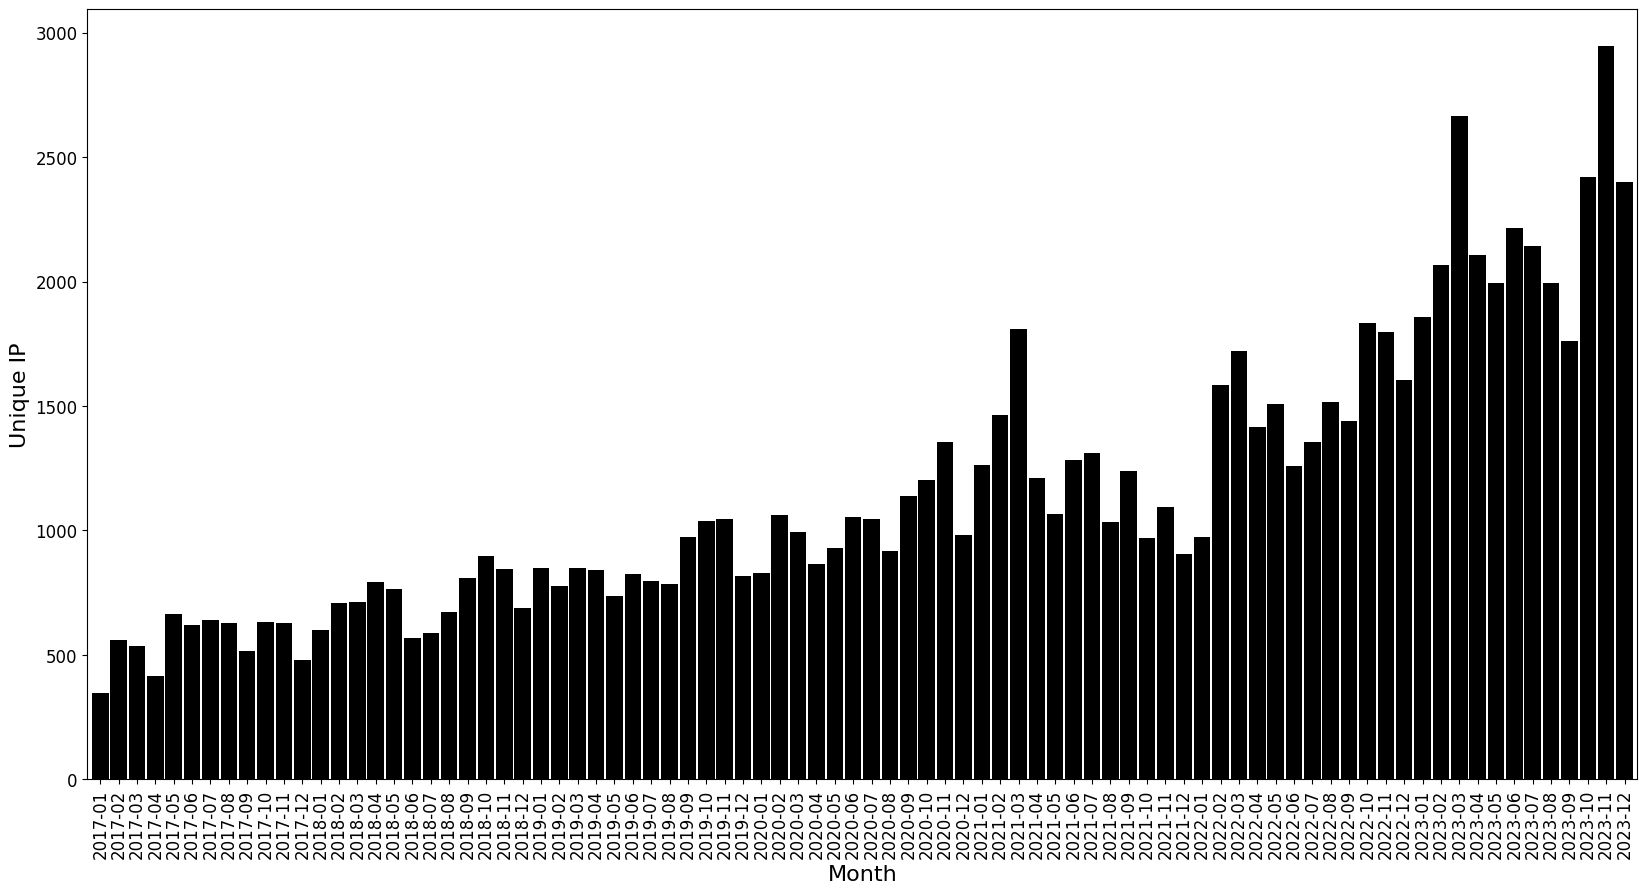

In [60]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='unique_ip', ylabel='Unique IP', xlabel='Month', x_rotation=90, fig_size=(20, 10))

## Total Number of request to the website per year and month

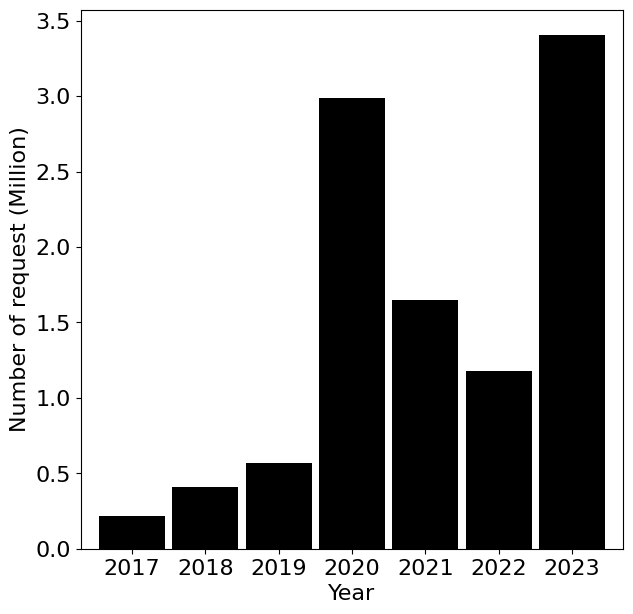

In [35]:
ax = draw_bar_plot(all_web_df_yearly, x='year', y='nb_request', ylabel='Number of request (Million)', xlabel='Year')

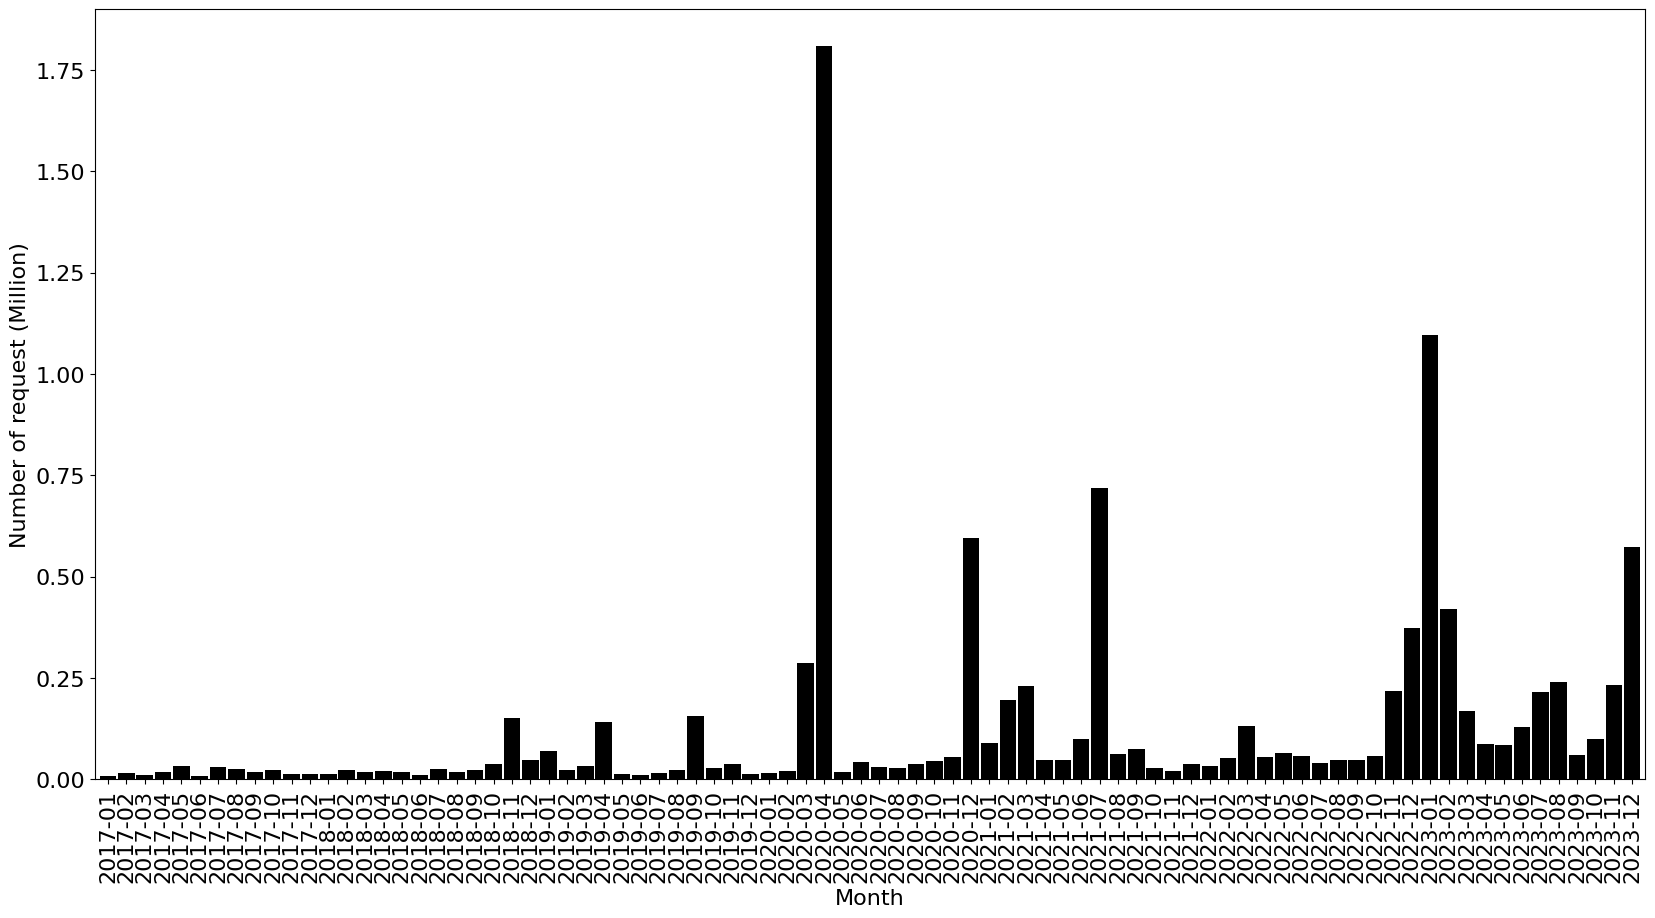

In [36]:
ax = draw_bar_plot(all_web_df_monthly, x='month', y='nb_request', ylabel='Number of request (Million)', xlabel='Month', x_rotation=90, fig_size=(20, 10))